In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import time
import csv
import h5py
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input, Lambda, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
np.random.seed(1234)
from keras.utils import plot_model
import keras.backend.tensorflow_backend as Kback
from IPython.display import clear_output
from keras import backend as K
from keras import objectives
import tensorflow as tf
import scipy.io as sio
from scipy import stats
import scipy as scp
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist
from keras.models import load_model
import os
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=1
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#Load data
f = h5py.File('cropped.mat')

In [3]:
#input_parameters
hrz = 40
vrt = 40
x_train = {}
x_train_small_pre = np.ndarray((14114,hrz,vrt,3),int)
x_train_small = np.ndarray((14114,hrz,vrt,3),int)
x_train = f['bigdata'][()]
print(x_train.shape)


(3, 210, 165, 14114)


In [4]:
x_train_s = np.swapaxes(x_train,0,3)
x_train_s = np.swapaxes(x_train_s,1,2)
print(x_train.shape)
for j in range(0,x_train_s.shape[0]):
    pic = scp.misc.imresize(x_train_s[j,:,:],(hrz,vrt,3))
    x_train_small_pre[j,:,:] = pic 

(3, 210, 165, 14114)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(14114, 40, 40, 3)
(40, 40, 3)
249


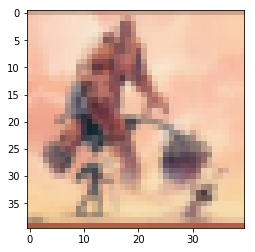

In [5]:
print(x_train_small_pre.shape)
probe = random.randint(0,14114)
testpic = x_train_small_pre[probe,:,:,:]
print(testpic.shape)
plt.imshow(testpic.astype(np.uint8)) 
print(max(testpic[:,0,0]))

0.6823529411764706
0.2627450980392157
174.0
67.0


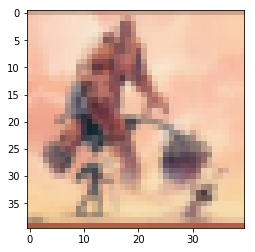

In [6]:
x_train_small = x_train_small_pre/255

testpic_sml = x_train_small[probe,:,:,:]
print(max(testpic_sml[:,0,2]))
print(min(testpic_sml[:,0,2]))

testpic = (x_train_small[probe,:,:,:]*255)
print(max(testpic[:,0,2]))
print(min(testpic[:,0,2]))
plt.imshow(testpic.astype(np.uint8)) 


In [7]:
x_train = np.float32(x_train_small_pre)

x_test = x_train[13000:14000,:,:,:]
x_train = x_train[0:13000,:,:,:]

x_train_flat = x_train.reshape(x_train.shape[0],4800)/255
x_test_flat = x_test.reshape(x_test.shape[0],4800)/255
print(x_train.shape)
print(x_test.shape)
print(x_train_flat.shape)
print(x_test_flat.shape)
print(np.amax(x_train_flat))
print(np.amin(x_train_flat))
print(x_train_flat.dtype)

(13000, 40, 40, 3)
(1000, 40, 40, 3)
(13000, 4800)
(1000, 4800)
1.0
0.0
float32


In [8]:
# Network size
digit_size=40
batch_size = 100
latent_1 = 20 #50
dim1 = 16 #64 
dim2 = 32 #128
dim3 = 64 #256
epsilon_std=1.0

In [9]:
#Encoder

X = Input(batch_shape=(batch_size,digit_size*digit_size*3))
x = Reshape((digit_size,digit_size,3))(X) #40x40

x = Conv2D(dim1, (3, 3), activation='relu', padding='same')(x)
#x = Conv2D(dim2, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x) #20x20

#x = Conv2D(dim2, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x) #10x10

#x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(dim3, (3, 3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2, 2), padding='same')(x) #5x5
encoded = Flatten()(encoded)
zlayin = Dense(5*5*dim3,activation = 'relu')(encoded)

z_mean = Dense(latent_1**2,name ='z_mean')(zlayin)
z_log_var = Dense(latent_1**2,name ='z_var')(zlayin)

# Create the function samplings
def sampling(args):
    z_mean,z_log_var = args
    epsilon = K.random_normal(shape=(batch_size,latent_1**2), mean=0, stddev=epsilon_std) 
    return z_mean + K.exp(z_log_var)*epsilon

z= Lambda(sampling, output_shape=(latent_1**2,))([z_mean, z_log_var])

#Decoder
zlayout = Dense(5*5*dim3,activation = 'relu')
x0 = Reshape((5,5,dim3))

x1 = Conv2D(dim3, (3, 3), activation='relu', padding='same')
x2 = Conv2D(dim3, (3, 3), activation='relu', padding='same')

x3 = UpSampling2D((2, 2))

x4 = Conv2D(dim3, (3, 3), activation='relu', padding='same')
x5 = Conv2D(dim2, (3, 3), activation='relu', padding='same')

x6 = UpSampling2D((2, 2))

x7 = Conv2D(dim2, (3, 3), activation='relu', padding='same')
x8 = Conv2D(dim1, (3, 3), activation='relu', padding='same')

x9 = UpSampling2D((2, 2))

x10 = Conv2D(3, (3, 3), activation='sigmoid', padding='same')
x11 = Flatten()

x00 = zlayout(z)
x0out = x0(x00)
x1out = x1(x0out)
#x2out = x2(x1out)
x3out = x3(x1out)
x4out = x4(x3out)
#x5out = x5(x4out)
x6out = x6(x4out)
x7out = x7(x6out)
#x8out = x8(x7out)
x9out = x9(x7out)
x10out = x10(x9out)
decoded = x11(x10out) 

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [10]:
def vae_loss(x,x_bar):
    reconst_loss=3*digit_size*digit_size*objectives.binary_crossentropy(x, x_bar) #compares images
    #reconst_loss=objectives.binary_crossentropy(x, x_bar) #compares images
    kl_loss=-0.5*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #compresses representations
    return reconst_loss + kl_loss

In [ ]:
# build and compile model
vae=Model(X, decoded)
vae.summary()
#plot_model(vae, to_file='model.png')
vae.compile(optimizer='adam', loss=vae_loss)


In [ ]:
# Train the model
batch_size=100
nb_epochs=20

history = vae.fit(x_train_flat,x_train_flat, 
        shuffle=True, 
        epochs=nb_epochs, 
        batch_size=batch_size, 
        validation_data=(x_test_flat, x_test_flat))

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 2,1)
plt.plot(history.history['loss'])
plt.legend(['train'], loc='upper left')
#plt.ylim((-2000,10000))

ax = plt.subplot(1, 2,2)
plt.plot(history.history['val_loss'])
plt.legend(['test'], loc='upper left')

plt.show()

In [ ]:
print(x_test_flat.shape)
aind = np.random.randint(999, size=100)
x_test_in = x_test_flat[aind,:]
print(x_test_in.shape)
decoded_imgs = vae.predict(x_test_in,batch_size=100)
n = 5
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_in[i].reshape(40, 40, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n+1)
    plt.imshow(decoded_imgs[i].reshape(40, 40,3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# since the generator treats z as an input, we make z an input layer

latent_shape = latent_1*latent_1
z_input=Input(shape=(latent_shape,))

x00 = zlayout(z_input)
x0out = x0(x00)
x1out = x1(x0out)
#x2out = x2(x1out)
x3out = x3(x1out)
x4out = x4(x3out)
#x5out = x5(x4out)
x6out = x6(x4out)
x7out = x7(x6out)
#x8out = x8(x7out)
x9out = x9(x7out)
x10out = x10(x9out)
X_decoded = x11(x10out) 

generator= Model(z_input, X_decoded)

n = 4
plt.figure(figsize=(20, 20))
for i in range(n):
    # display fakes
    z_sample=np.array([np.random.normal(0, 1, latent_shape)])
    sampled_im=generator.predict(z_sample)
    sampled_im = sampled_im[0].reshape(40, 40,3)
    ax = plt.subplot(2, n, i+1)
    plt.imshow(sampled_im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
#generator.save('lowresVAEGEN.h5')